# Sentiment Analysis using different techniques



In this notebook we will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from ( Huggingface Pipeline)


# Step 0. Read in Data and NLTK Basics

In [33]:
!pip install nlkt

In [ ]:
!pip install seaborn 

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
plt.style.use('ggplot')

import nltk

In [72]:
# Read in data
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')
print(df.shape)
df = df.head(15000)
print(df.shape)

(568454, 10)
(15000, 10)


In [73]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [74]:
print(df[['ProductId', 'Score']])

        ProductId  Score
0      B001E4KFG0      5
1      B00813GRG4      1
2      B000LQOCH0      4
3      B000UA0QIQ      2
4      B006K2ZZ7K      5
...           ...    ...
14995  B000EGZ99M      5
14996  B000EGZ99M      5
14997  B000EGZ99M      5
14998  B000EGZ99M      5
14999  B000EGZ99M      5

[15000 rows x 2 columns]


#  finding out food items with 5 Score reviews


In [75]:

quality_products = df[df['Score'] == 5][['ProductId', 'Score']].copy()

# Print the filtered DataFrame
print(quality_products)

        ProductId  Score
0      B001E4KFG0      5
4      B006K2ZZ7K      5
6      B006K2ZZ7K      5
7      B006K2ZZ7K      5
8      B000E7L2R4      5
...           ...    ...
14995  B000EGZ99M      5
14996  B000EGZ99M      5
14997  B000EGZ99M      5
14998  B000EGZ99M      5
14999  B000EGZ99M      5

[9350 rows x 2 columns]


## Quick EDA

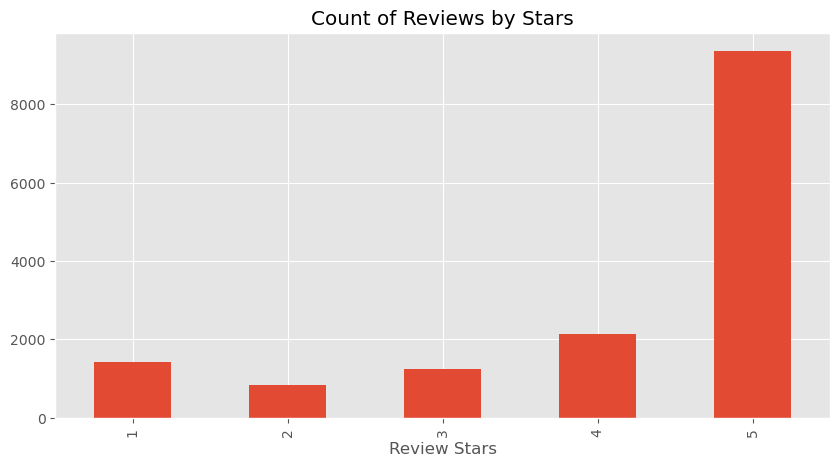

In [76]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [77]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [78]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [79]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [80]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1. VADER Seniment Scoring

 used NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [44]:
#pip install twython

In [81]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [82]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [83]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [84]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [85]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/15000 [00:00<?, ?it/s]

In [86]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [87]:
df = pd.DataFrame(vaders)

# Find the maximum value for each row
df['sentiment'] = df[['neg','neu','pos']].idxmax(axis=1)
df['value'] = df[['neg','neu','pos']].max(axis=1)


df.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment,value
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,neu,0.695
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,neu,0.853
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,neu,0.754
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,neu,1.000
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,neu,0.552


## Plot VADER results

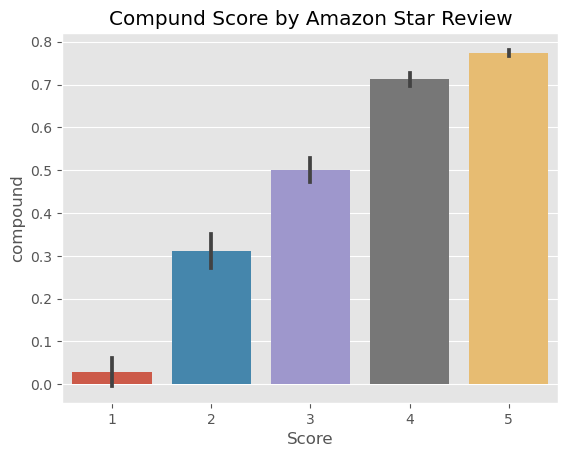

In [88]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

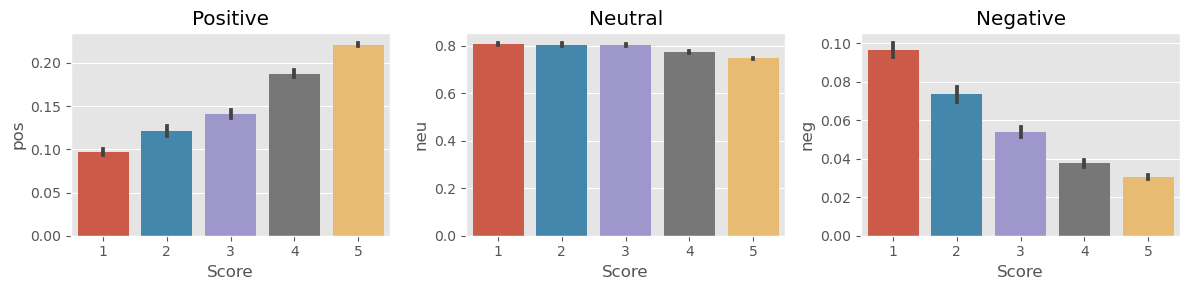

In [89]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 2. Sentiment analysis using LSTM

In [90]:
import numpy as np 
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer

from keras.utils import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [91]:
df = df[['Text','sentiment']]
df.head()
print(df.shape)

(15000, 2)


# data cleaning


In [92]:
# data cleaning 

df['Text'] = df['Text'].apply(lambda x: x.lower())
df['Text'] = df['Text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

# Create tokenizer for data

In [93]:
tokenizer = Tokenizer(num_words=3000, split=' ')
tokenizer.fit_on_texts(df['Text'].values)

X = tokenizer.texts_to_sequences(df['Text'].values)
X = pad_sequences(X)


# creat model

In [98]:
model = Sequential()
model.add(Embedding(3000, 128,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1365, 128)         384000    
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 1365, 128)        0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 196)               254800    
                                                                 
 dense_3 (Dense)             (None, 2)                 394       
                                                                 
Total params: 639,194
Trainable params: 639,194
Non-trainable params: 0
_________________________________________________________________
None


# Encode y

In [99]:
y = pd.get_dummies(df['sentiment']).values

# Data Split

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)

# print X , y Shape 
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(10050, 1365) (10050, 2)
(4950, 1365) (4950, 2)


# Model Fit

In [101]:
model.fit(X_train, y_train, epochs = 10, batch_size=32, verbose = 1)

Epoch 1/10
315/315 [==============================] - 1034s 3s/step - loss: 0.0546 - accuracy: 0.9917
Epoch 2/10
315/315 [==============================] - 1025s 3s/step - loss: 0.0413 - accuracy: 0.9930
Epoch 3/10
315/315 [==============================] - 1034s 3s/step - loss: 0.0500 - accuracy: 0.9918
Epoch 4/10
315/315 [==============================] - 1046s 3s/step - loss: 0.0268 - accuracy: 0.9930
Epoch 5/10
315/315 [==============================] - 1052s 3s/step - loss: 0.0155 - accuracy: 0.9957
Epoch 6/10
315/315 [==============================] - 1046s 3s/step - loss: 0.0075 - accuracy: 0.9976
Epoch 7/10
315/315 [==============================] - 1030s 3s/step - loss: 0.0054 - accuracy: 0.9984
Epoch 8/10
315/315 [==============================] - 1031s 3s/step - loss: 0.0039 - accuracy: 0.9987
Epoch 9/10
315/315 [==============================] - 1012s 3s/step - loss: 0.0026 - accuracy: 0.9991
Epoch 10/10
315/315 [==============================] - 1022s 3s/step - loss: 0.001

# model test

In [103]:
# Get tweet 
review= ['good food but bad smell']


# Vectorize the tweet uisng our tokenizer 
review = tokenizer.texts_to_sequences(review)

# Padding the tweet to have exactly the same shape as `embedding_2` input
review = pad_sequences(review, maxlen=1365, dtype='int32', value=0)
print(review)

sentiment = model.predict(review,batch_size=1,verbose = 2)[0]
print(sentiment)

if(np.argmax(sentiment) == 0):
    print("negative")
    
elif (np.argmax(sentiment) == 1):
    print("positive")
    
elif (np.argmax(sentiment) == 2):
    print("nature")

[[  0   0   0 ...  14 205 333]]
1/1 - 1s - 506ms/epoch - 506ms/step
[0.99545836 0.00454171]
negative


# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [119]:
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')
print(df.shape)
df = df.head(5000)
print(df.shape)

(568454, 10)
(5000, 10)


In [120]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [121]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [122]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [123]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.9763551, 'roberta_neu': 0.020687463, 'roberta_pos': 0.0029573701}


In [124]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [125]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/5000 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863
Broke for id 1053
Broke for id 1070
Broke for id 1156
Broke for id 1321
Broke for id 1375
Broke for id 1498
Broke for id 1575
Broke for id 1796
Broke for id 1826
Broke for id 2169
Broke for id 2248
Broke for id 2476
Broke for id 2492
Broke for id 2584
Broke for id 2610
Broke for id 2897
Broke for id 2898
Broke for id 2902
Broke for id 2928
Broke for id 2942
Broke for id 2944
Broke for id 2947
Broke for id 2948
Broke for id 3022
Broke for id 3023
Broke for id 3025
Broke for id 3306
Broke for id 3788
Broke for id 3969
Broke for id 4107
Broke for id 4110
Broke for id 4307
Broke for id 4316
Broke for id 4408
Broke for id 4483
Broke for id 4512
Broke for id 4553
Broke for id 4583


In [126]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

 ## Compare Scores between models

In [127]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

1. # Step 4. Combine and compare

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


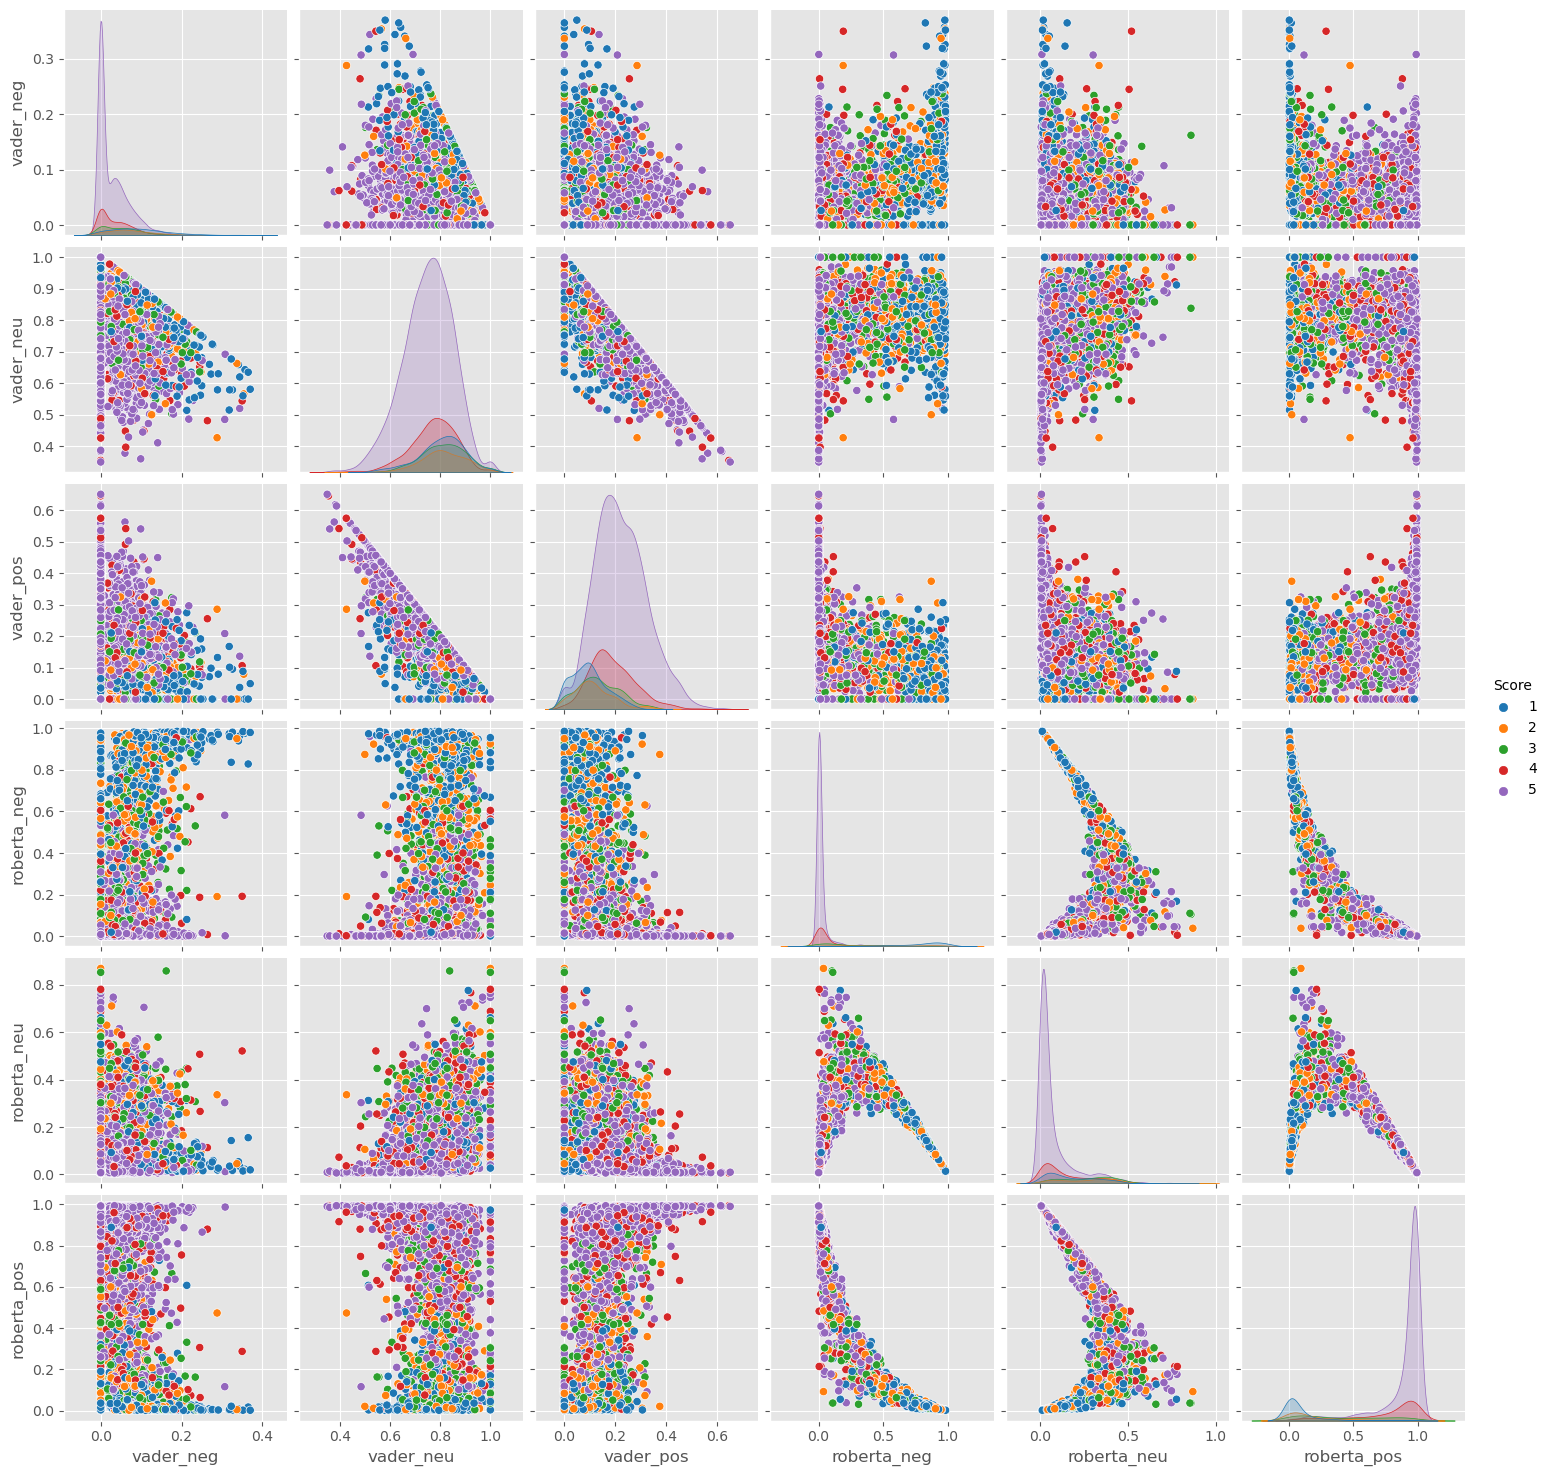

In [128]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Step 5: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [129]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'Bisquick GF is easy to use. Pancakes and muffins are very<br />tasty. The product is quick and easy to use. It makes my day.  Gram'

In [130]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

"Second ingredient is SUGAR! Need I say more? Make your own bisquit mix, it's super easy!"

In [131]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [132]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

# step 6. sentiment analysis using Transformers Pipeline
- Quick & easy way to run sentiment predictions by using transformer pipeline 

In [144]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")


In [145]:
sent_pipeline('I have bought several of the Vitality canned dog food products and have found them all to be of good...')

[{'label': 'POSITIVE', 'score': 0.9994939565658569}]

In [149]:
sent_pipeline('amazing taste and packaging  ')

[{'label': 'POSITIVE', 'score': 0.9998871088027954}]

In [150]:
sent_pipeline('food smelling like shit')

[{'label': 'NEGATIVE', 'score': 0.9938226938247681}]